## 🌐 Connect to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/
%cd [2024-2025] AN2DL Homework 1/

Mounted at /gdrive
/gdrive/My Drive
/gdrive/My Drive/[2024-2025] AN2DL Homework 1


## 🛠 Fix Codabench Dependencies

In [2]:
# Creates a file in which we specify the versions of the libraries we want
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


## ⚙️ Import Libraries

In [4]:
import numpy as np
import logging

!pip install keras-cv

import tensorflow as tf
import keras_cv as kcv
import keras as tfk
from keras import layers as tfkl

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seeds for NumPy and TensorFlow
seed = 29
np.random.seed(seed)
tf.random.set_seed(seed);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 52.5 MB/s eta 0:00:00


## ⏳ Load and Clean the Data

In [5]:
# Load the dataset
data = np.load('training_set.npz')

# Put images on X and labels on y
X = data['images']
y = data['labels']

print("Initial X shape: ", X.shape)
print("Initial y shape: ", y.shape)

# Delete outliers from the dataset
delete_index = 11958
X = X[:delete_index + 1]
y = y[:delete_index + 1]

print("Final X shape: ", X.shape)
print("Final y shape: ", y.shape)

Initial X shape:  (13759, 96, 96, 3)
Initial y shape:  (13759, 1)
Final X shape:  (11959, 96, 96, 3)
Final y shape:  (11959, 1)


## 🚆 Split into train, validation and train sets

In [ ]:
# Split the dataset into a training + validation set, and a separate test set
# The test set is the 10% of the whole dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed)

# Further split the training + validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=len(X_test),
    stratify=y_train_val,
    random_state=seed)

# Convert labels to one-hot encoding
y_train = tfk.utils.to_categorical(y_train, 8)
y_val = tfk.utils.to_categorical(y_val, 8)
y_test = tfk.utils.to_categorical(y_test, 8)

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Training set shape:	 (9567, 96, 96, 3) (9567, 8)
Validation set shape:	 (1196, 96, 96, 3) (1196, 8)
Test set shape:		 (1196, 96, 96, 3) (1196, 8)


## 🧮 Define Network Parameters

In [7]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

# Number of training epochs
epochs = 100

# Number of samples passed to the network at each training step
batch_size = 16

# Learning rate: step size for updating the model's weights
learning_rate = 1e-5

# L2 Lambda for regularization
l2_lambda = 1e-5

## 🆙  Define Image Augmentation Pipeline

In [8]:
augmix = kcv.layers.AugMix(
    value_range=(0, 255),
    severity=0.1,
    num_chains=1,
    chain_depth=[1, 2],
    alpha=0.5,
    dtype="float32",
    seed=seed,
)

gridmask = kcv.layers.GridMask(
    ratio_factor=(0, 0.3),
    rotation_factor=0.1,
    fill_mode="constant",
    fill_value=0.0,
    dtype="float32",
    seed=seed,
)

randaugment = kcv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=1,
    magnitude=0.2,
    magnitude_stddev=0.1,
    rate=0.3,
    geometric=False,
    dtype="float32",
    seed=seed,
)

channel_shuffle = kcv.layers.ChannelShuffle(
    dtype="float32",
    seed=seed,
)

random_hue = kcv.layers.RandomHue(
    factor=(0, 0.05),
    value_range=(0, 255),
    dtype="float32",
    seed=seed,
)

random_shear = kcv.layers.RandomShear(
    x_factor=(0, 0.3),
    y_factor=(0, 0.3),
    interpolation="bilinear",
    fill_mode="constant",
    fill_value=0.0,
    dtype="float32",
    seed=seed,
)

random_flip = tfk.layers.RandomFlip("horizontal_and_vertical")
random_rotation = tfk.layers.RandomRotation(0.2)

augmentation = tfk.Sequential([
    gridmask,
    channel_shuffle,
    random_hue,
    random_shear,
    random_flip,
    random_rotation,
])

# Cast the dtype to float32 to apply Augmentation Pipeline
tfk.mixed_precision.set_global_policy('float32')

## ⏯ Preprocess dataset

In [9]:
# Define preprocessing functions
def preprocess_image(image):
    image = tf.convert_to_tensor(image)
    image = tf.cast(image, dtype=tf.float32)
    return image

def apply_augmentation(image, label):
    image = augmentation(image)
    return image, label

# Create the training dataset with augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda img, label: (preprocess_image(img), label), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=12000, seed=seed)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Create the validation dataset without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(lambda img, label: (preprocess_image(img), label), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

## 🖌 Plot Augmented Dataset

Augmented Dataset:


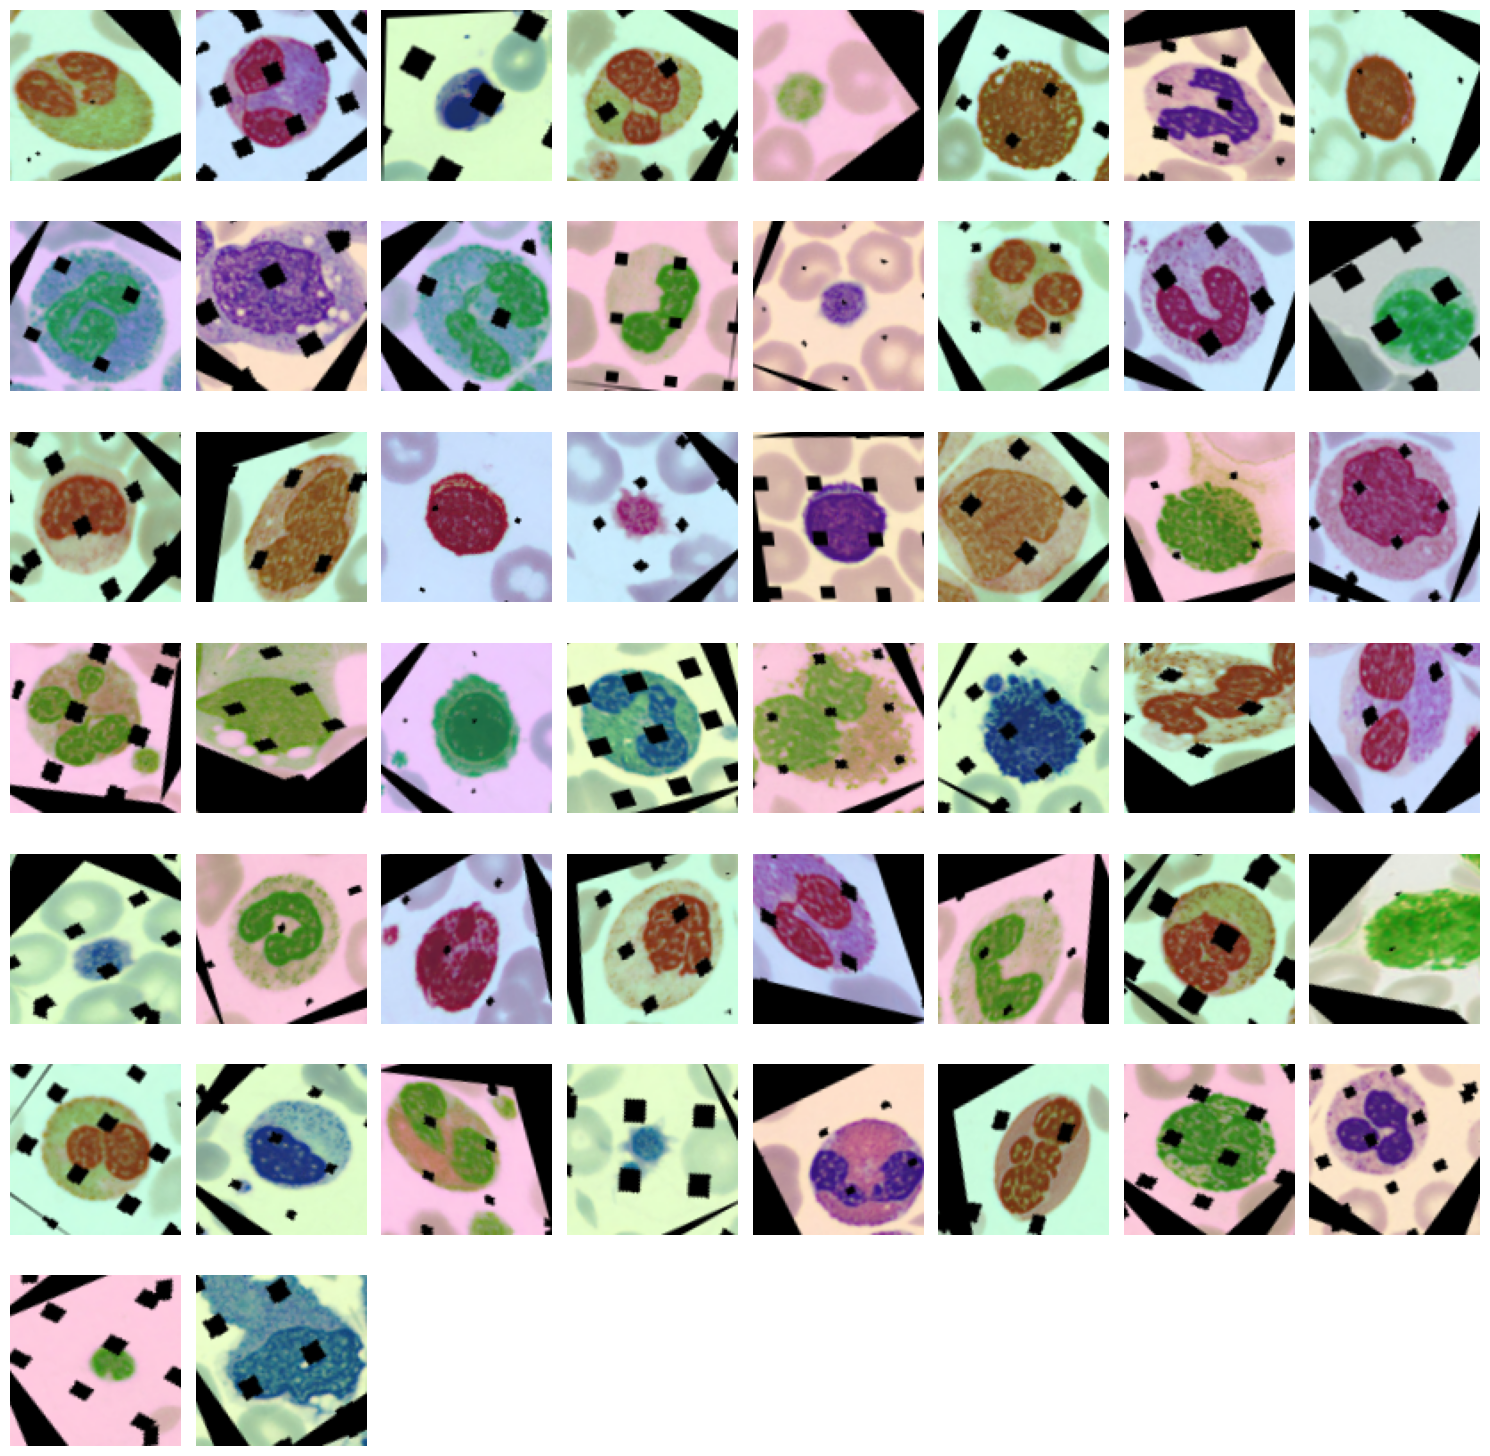

In [10]:
def plot_images_from_dataset(dataset, num_images=50):

    # Prepare a dataset iterator
    dataset_iterator = iter(dataset)

    # Calculate the number of rows and columns for the grid
    rows = int(num_images ** 0.5)
    cols = (num_images + rows - 1) // rows  # Round Up

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        try:
            # Get a batch of images and labels
            images, labels = next(dataset_iterator)

            # Take first image from the batch
            image = images[0].numpy().astype("uint8")

            # Plot the image
            plt.subplot(rows, cols, i + 1)
            plt.imshow(image)
            plt.axis('off')
        except StopIteration:
            print("No images in the dataset.")
            break

    plt.tight_layout()
    plt.show()

# Plot images from the dataset
print("Augmented Dataset:")
plot_images_from_dataset(train_dataset, num_images=50)

## 🔨 Import and tune the Model

In [11]:
# Import and initialize ResNet50V2
model = tfk.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    classes=output_shape,
    classifier_activation='softmax',
)

# Initialize regularizer
regularizer = tfk.regularizers.L2(l2_lambda)

# Freeze all layers to use the model solely as a feature extractor
model.trainable = False

# Create input layer
inputs = tfkl.Input(shape=input_shape)

# Connect model with inputs
x = model(inputs, training=False)

# Add layers
x = tfkl.Dense(1024, activation='relu', kernel_regularizer=regularizer)(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)
x = tfkl.Dense(1024, activation='relu', kernel_regularizer=regularizer)(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)

# Setup Fully Connected Blocks
x = tfkl.Dropout(rate=0.3)(x)
outputs = tfkl.Dense(units=output_shape, activation='softmax', dtype='float32')(x)

# Connect input and output
model = tfk.Model(inputs=inputs, outputs=outputs)

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Lion(learning_rate=learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 🧠 Train the Model for Transfer Learning

In [12]:
# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Create a LearningRate Scheduler, which reduces learning rate if val_loss doesn't improve
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Store the callback in a list
callbacks = [early_stopping, lr_scheduler]

In [13]:
tl_history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_dataset),
    callbacks=callbacks
).history

print('Training finished.')

# Calculate and print the final validation accuracy
tl_final_val_accuracy = round(max(tl_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {tl_final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
tl_model_filename = 'ResNet50V2' + str(tl_final_val_accuracy) + '.keras'
model.save(tl_model_filename)

# Free memory by deleting the model instance
del model

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 83s 40ms/step - accuracy: 0.2096 - loss: 3.3242 - val_accuracy: 0.4624 - val_loss: 1.4515 - learning_rate: 1.0000e-05
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.3358 - loss: 2.4481 - val_accuracy: 0.5627 - val_loss: 1.2958 - learning_rate: 1.0000e-05
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.3780 - loss: 2.2164 - val_accuracy: 0.6513 - val_loss: 1.0266 - learning_rate: 1.0000e-05
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.4025 - loss: 2.0645 - val_accuracy: 0.5886 - val_loss: 1.1892 - learning_rate: 1.0000e-05
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.4231 - loss: 1.9324 - val_accuracy: 0.5811 - val_loss: 1.1729 - learning_rate: 1.0000e-05
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.4170 - loss: 1.8733 - val_accuracy: 0.5962 - val_loss: 1.0625 - learning_rate: 1.0000e-05
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 1

## 🔧 Fine Tuning

In [14]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model(tl_model_filename)

# Set the model layers as trainable
ft_model.get_layer('resnet50v2').trainable = True

# Set all layers as non-trainable
for layer in ft_model.get_layer('resnet50v2').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [15]:
# Set the number of layers to freeze
N = 200

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:N]):
    layer.trainable = False

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Lion(learning_rate=learning_rate)
metrics = ['accuracy']
ft_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## 🧠 Train Fine-Tuned Model

In [16]:
ft_history = ft_model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_dataset),
    callbacks=callbacks
).history

print('Training finished.')

# Calculate and print the final validation accuracy
ft_final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {ft_final_val_accuracy}%')

# Save the trained model to a file
ft_model.save('weights.keras')

# Free memory by deleting the model instance
del ft_model

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.4834 - loss: 1.4993 - val_accuracy: 0.4156 - val_loss: 2.1535 - learning_rate: 1.0000e-05
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.4814 - loss: 1.4938 - val_accuracy: 0.6497 - val_loss: 1.0297 - learning_rate: 1.0000e-05
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.4897 - loss: 1.4595 - val_accuracy: 0.6781 - val_loss: 0.8658 - learning_rate: 1.0000e-05
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.4947 - loss: 1.4381 - val_accuracy: 0.6179 - val_loss: 1.0080 - learning_rate: 1.0000e-05
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.5062 - loss: 1.3655 - val_accuracy: 0.5970 - val_loss: 1.0340 - learning_rate: 1.0000e-05
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.5168 - loss: 1.3559 - val_accuracy: 0.7249 - val_loss: 0.7982 - learning_rate: 1.0000e-05
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 81s 1

## ✅ Verify that the weights work as intended

In [17]:
# Load the model
model = tfk.models.load_model('weights.keras')

# Predict on test set and validation set
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Convert to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute accuracy
test_accuracy = np.sum(y_test_classes == y_pred_test_classes) / len(y_test_classes)
val_accuracy = np.sum(y_val_classes == y_pred_val_classes) / len(y_val_classes)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Validation Accuracy: 0.4156
Test Accuracy: 0.4365


## 📊 Create the model.py

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


## 📁 Export the ZIP file

In [ ]:
# Set filename for the zip file
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create a zip file with the provided filename, containing model and weights
!zip {filename} model.py weights.keras

  adding: model.py (deflated 49%)
  adding: weights.keras (deflated 8%)
